# Goal
We want to predict a few different sets of 15d data in 2017, to see how we might perform on test data


On features:
- Want to use many features + LGBM type shit
    - maybe we train on a few months, but those months are using features that shift for years
    - then we test on 15d
- We make features FIRST
    - ex. 1d lag, 14d lag, 1 year, % difs.
    - in reality we won't actually have 1d lag on everything, but presume that we do

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import root_mean_squared_log_error, root_mean_squared_error

In [57]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
transactions_df = pd.read_csv('data/transactions.csv')
oil_df = pd.read_csv('data/oil.csv')
holidays_df = pd.read_csv('data/holidays_events.csv')
stores_df = pd.read_csv('data/stores.csv')

train_df = train_df.drop(columns='id')
train_df['date'] = pd.to_datetime(train_df['date'])

mask = oil_df.isna().sum(axis=1).astype(bool)
oil_df = oil_df.ffill().bfill()
oil_df['date'] = pd.to_datetime(oil_df['date'])

# Feature Engineering

Same fam/store
1. Lagged sales (1d, 7d, etc. lag - same fam/store)
2. Rolling sales (1d, 7d, etc. roll - same fam/store)
3. Day of month effect (same day / all days of month, same day / prev day - same fam/store)
4. Yearly fluctuations (day of year / prev day, day of year / prev 7 days - same fam/store)

In [58]:
# FEATURE ENGINEERING TIME

# combined will be the running combined df
lag_features = train_df.copy()

# 1. 14d ago lag
for lag in ['14D', '15D', '16D', '21D']:
    shiftd = train_df.copy()
    shiftd['date'] = shiftd['date'] + pd.Timedelta(lag)
    shiftd = shiftd[['date', 'store_nbr', 'family', 'sales']].rename(columns={'sales': f'sales{lag}'})
    lag_features = pd.merge(lag_features, shiftd, how='inner', on=['date', 'store_nbr', 'family'])

lag_features.head(20)

,date,store_nbr,family,sales,onpromotion,sales14D,sales15D,sales16D,sales21D
0,2013-01-22,1,AUTOMOTIVE,1.000,0,2.000,0.000,2.000,0.0
1,2013-01-22,1,BABY CARE,0.000,0,0.000,0.000,0.000,0.0
2,2013-01-22,1,BEAUTY,1.000,0,3.000,1.000,0.000,0.0
3,2013-01-22,1,BEVERAGES,1037.000,0,1029.000,1158.000,407.000,0.0
4,2013-01-22,1,BOOKS,0.000,0,0.000,0.000,0.000,0.0
5,2013-01-22,1,BREAD/BAKERY,299.201,0,321.851,309.676,147.182,0.0
6,2013-01-22,1,CELEBRATION,0.000,0,0.000,0.000,0.000,0.0
7,2013-01-22,1,CLEANING,777.000,0,827.000,829.000,257.000,0.0
8,2013-01-22,1,DAIRY,347.000,0,384.000,400.000,212.000,0.0
9,2013-01-22,1,DELI,99.297,0,130.085,113.235,60.135,0.0


In [4]:
# 2. rolling (over the past 1w, what is avg)
rolling_features = lag_features.copy()

for lag in ['7D', '14D', '28D', '365D']:
    rollingd = lag_features.groupby(['store_nbr', 'family']).rolling(lag, on='date')['sales14D'].mean()
    rollingd = rollingd.reset_index()[['date', 'store_nbr', 'family', 'sales14D']].rename(columns={'sales14D': f'rolling{lag}'})
    rolling_features = pd.merge(rolling_features, rollingd, how='inner', on=['date', 'store_nbr', 'family'])

rolling_features = rolling_features.dropna(axis=0)
rolling_features.head(10)


,date,store_nbr,family,sales,onpromotion,sales14D,sales21D,rolling7D,rolling14D,rolling28D,rolling365D
0,2013-01-22,1,AUTOMOTIVE,1.000,0,2.000,0.0,2.000,2.000,2.000,2.000
1,2013-01-22,1,BABY CARE,0.000,0,0.000,0.0,0.000,0.000,0.000,0.000
2,2013-01-22,1,BEAUTY,1.000,0,3.000,0.0,3.000,3.000,3.000,3.000
3,2013-01-22,1,BEVERAGES,1037.000,0,1029.000,0.0,1029.000,1029.000,1029.000,1029.000
4,2013-01-22,1,BOOKS,0.000,0,0.000,0.0,0.000,0.000,0.000,0.000
5,2013-01-22,1,BREAD/BAKERY,299.201,0,321.851,0.0,321.851,321.851,321.851,321.851
6,2013-01-22,1,CELEBRATION,0.000,0,0.000,0.0,0.000,0.000,0.000,0.000
7,2013-01-22,1,CLEANING,777.000,0,827.000,0.0,827.000,827.000,827.000,827.000
8,2013-01-22,1,DAIRY,347.000,0,384.000,0.0,384.000,384.000,384.000,384.000
9,2013-01-22,1,DELI,99.297,0,130.085,0.0,130.085,130.085,130.085,130.085


In [5]:
# 3. day of week for the last month

dow_features = rolling_features.copy()
dow_features['day_of_week'] = dow_features['date'].dt.day_of_week

for lag in ['7D', '14D', '28D', '365D']:
    same_dow = dow_features.groupby(['store_nbr', 'family', 'day_of_week']).rolling(lag, on='date')['sales14D'].mean()
    same_dow = same_dow.rename(f'dow{lag}')
    dow_features = pd.merge(dow_features, same_dow, on=['store_nbr', 'family', 'date'])

In [6]:
# 4. ratios of rolling to dow

ratio = dow_features.copy()
for lag in ['7D', '14D', '28D', '365D']:
    ratio[f'dowratio{lag}'] = ratio[f'rolling{lag}'] / ratio[f'dow{lag}']

In [7]:
# 5. account for monthly differences
dom_features = ratio.copy()
dom_features['day_of_month'] = dom_features['date'].dt.day

for lag in ['31D', '61D', '91D', '121D']:
    # same day of month, rolling avg.
    same_dom = dom_features.groupby(['store_nbr', 'family', 'day_of_month']).rolling(lag, on='date')['sales14D'].mean() # avg. of same day of month over last x months
    same_dom = same_dom.rename(f'dom{lag}')
    dom_features = pd.merge(dom_features, same_dom, on=['store_nbr', 'family', 'date'])

    # just the month as normal, rolling avg.
    dom_rolling = dom_features.groupby(['store_nbr', 'family']).rolling(lag, on='date')['sales14D'].mean()
    dom_rolling = dom_rolling.rename(f'rolling{lag}')
    dom_features = pd.merge(dom_features, dom_rolling, on=['store_nbr', 'family', 'date'])

    # ratio
    dom_features[f'domratio{lag}'] = dom_features[f'dom{lag}'] / dom_features[f'rolling{lag}']

dom_features.head()

,date,store_nbr,family,sales,onpromotion,sales14D,sales21D,rolling7D,rolling14D,rolling28D,...,domratio31D,dom61D,rolling61D,domratio61D,dom91D,rolling91D,domratio91D,dom121D,rolling121D,domratio121D
0,2013-01-22,1,AUTOMOTIVE,1.0,0,2.0,0.0,2.0,2.0,2.0,...,1.0,2.0,2.0,1.0,2.0,2.0,1.0,2.0,2.0,1.0
1,2013-01-22,1,BABY CARE,0.0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN
2,2013-01-22,1,BEAUTY,1.0,0,3.0,0.0,3.0,3.0,3.0,...,1.0,3.0,3.0,1.0,3.0,3.0,1.0,3.0,3.0,1.0
3,2013-01-22,1,BEVERAGES,1037.0,0,1029.0,0.0,1029.0,1029.0,1029.0,...,1.0,1029.0,1029.0,1.0,1029.0,1029.0,1.0,1029.0,1029.0,1.0
4,2013-01-22,1,BOOKS,0.0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN


In [59]:
# 6. is holiday
holiday_features = lag_features.copy()

holidays_df['date'] = pd.to_datetime(holidays_df['date'])
holiday_features['is_holiday'] = holiday_features['date'].isin(holidays_df['date'])

shifted_holiday = holiday_features.copy()
shifted_holiday['date'] = shifted_holiday['date'] + pd.Timedelta('14D')
shifted_holiday = shifted_holiday[['date', 'is_holiday', 'store_nbr', 'family']].rename(columns={'is_holiday': 'shift_is_holiday'})

holiday_features = pd.merge(holiday_features, shifted_holiday, on=['date', 'store_nbr', 'family'], how='inner')

# Modelling
Using all our features, we now need to predict

- "Cross Val": predicting different time periods in 2017 using prev. year data
    - train on 2013 - 2016, test on 2017 (simply pass in lagged features)

In [60]:
# Modified to change object to category
def memory_reduce(df):
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type.name != 'category':
            if np.issubdtype(col_type, np.integer):
                df[col] = pd.to_numeric(df[col], downcast='integer')
            elif np.issubdtype(col_type, np.floating):
                df[col] = pd.to_numeric(df[col], downcast='float')

        if col_type == object:
            df[col] = df[col].astype('category')
    
    end_mem = df.memory_usage().sum() / 1024**2
    print(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB "
          f"({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")
    return df


cleaned = holiday_features.copy()
cleaned = memory_reduce(cleaned)

Memory usage reduced from 203.35 MB to 148.39 MB (27.0% reduction)


In [61]:
import lightgbm as lgb

dates = cleaned['date']
X = cleaned.drop(columns=['date', 'sales'])
y = cleaned['sales']

X_train, y_train = X[dates < pd.to_datetime('2017-01-01')], y[dates < pd.to_datetime('2017-01-01')]
X_test, y_test = X[dates >= pd.to_datetime('2017-01-01')], y[dates >= pd.to_datetime('2017-01-01')]

In [62]:
categorical_features = X_train.select_dtypes(include='category').columns

model = lgb.LGBMRegressor(
            n_estimators=100,
            num_leaves=31,
            learning_rate = 0.1
        )

model.fit(X_train,
          np.log1p(y_train),
          categorical_feature=categorical_features)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1303
[LightGBM] [Info] Number of data points in the train set: 2491236, number of used features: 9
[LightGBM] [Info] Start training from score 2.842957


LGBMRegressor()

In [63]:
predictions = model.predict(X_test)
root_mean_squared_error(predictions, np.log1p(y_test))

0.5651143860383566

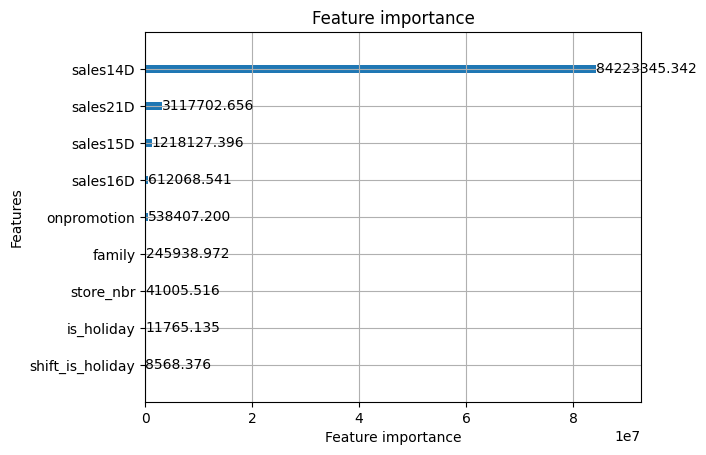

In [64]:
lgb.plot_importance(model, max_num_features=10, importance_type='gain')  # or 'gain'
plt.show()

In [21]:
# Try Grid Search (this is CV version)
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'reg_alpha': [0],
    'reg_lambda': [0,1,100]
    }

model = lgb.LGBMRegressor()

grid_search = GridSearchCV(
    estimator=model,
    param_grid=params,
    n_jobs=-1
)

grid_search.fit(
    X_train,
    np.log1p(y_train),
    categorical_feature=categorical_features
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.060641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3868
[LightGBM] [Info] Number of data points in the train set: 2038608, number of used features: 18
[LightGBM] [Info] Start training from score 3.009334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3862
[LightGBM] [Info] Number of data points in the train set: 2038608, number of used features: 18
[LightGBM] [Info] Start training from score 2.851193
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Tota

GridSearchCV(estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1], 'n_estimators': [100],
                         'reg_alpha': [0], 'reg_lambda': [0]})

In [38]:
from itertools import product

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'reg_alpha': [1,10,100],
    'reg_lambda': [1,10,100]
    }

results = []

for params in product(*param_grid.values()):
    param_combination = dict(zip(param_grid.keys(), params))
    
    model = lgb.LGBMRegressor(**param_combination)
    
    model.fit(
        X_train,
        np.log1p(y_train),
        eval_set=[(X_test, np.log1p(y_test))],
        eval_metric='rmse',
        categorical_feature=categorical_features,
        callbacks=[lgb.early_stopping(50, verbose=0)]
    )
    
    predictions = model.predict(X_test)
    rmse = root_mean_squared_error(np.log1p(y_test), predictions)
    
    results.append((params, rmse))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3856
[LightGBM] [Info] Number of data points in the train set: 2548260, number of used features: 18
[LightGBM] [Info] Start training from score 2.836902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3856
[LightGBM] [Info] Number of data points in the train set: 2548260, number of used features: 18
[LightGBM] [Info] Start training from score 2.836902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

In [39]:
results.sort(key=lambda x : -x[-1])

for res in results:
    print(res)

((100, 0.1, 100, 100), 0.5514664183173252)
((100, 0.1, 100, 10), 0.550142164543125)
((100, 0.1, 100, 1), 0.550119004882933)
((100, 0.1, 10, 100), 0.54982690374394)
((100, 0.1, 1, 100), 0.5495649186938206)
((100, 0.1, 10, 1), 0.5494609163624529)
((100, 0.1, 10, 10), 0.5490830439403638)
((100, 0.1, 1, 10), 0.5485802846371367)
((100, 0.1, 1, 1), 0.548516514610736)
